## Physics-Based CNN for Super-Resolution & Denoising of Fluid Flow Data

In [1]:
# IMPORTING THE LIBRARIES
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, TensorDataset
import vtk
from vtk.util import numpy_support as VN

In [2]:
# ***** CHOOSE A PROCESSING UNIT FOR COMPUTATION: CPU or GPU

processor = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("AVAILABLE PROCESSOR:", processor, '\n')

AVAILABLE PROCESSOR: cuda 



In [3]:
#FLOW PROPERTIES
rho = 1.225
diffusion = 1.48 *(10**(-5))

In [4]:
# ***** READING THE SOLUTION FILE
data  = np.genfromtxt('CFD_Solution.csv', delimiter=",")
Nx    = int(np.sqrt(data.shape[0]))                          # RESOLUTION OF A GRID

print("RESOLUTION OF THE GRID USED FOR CFD SIMULATION = ", Nx)

u = data[:, 5]
v = data[:, 6]
p = data[:, 2]

U = np.zeros((Nx, Nx))
V = np.zeros((Nx, Nx))
P = np.zeros((Nx, Nx))

for i in range(Nx):
    for j in range(Nx):
        U[i, j] = u[(i*Nx)+ j]
        V[i, j] = v[(i*Nx)+ j]
        P[i, j] = p[(i*Nx)+ j]
        
# NORMALISATION OF DATA
Umax = np.max(U)
Umin = np.min(U)
U = (U - Umax)/ (Umax- Umin) + (U - Umin)/ (Umax- Umin)

Vmax = np.max(V)
Vmin = np.min(V)
V = (V - Vmax)/(Vmax - Vmin) + (V - Vmin)/(Vmax - Vmin)

Pmax = np.max(P)
Pmin = np.min(P)
P = (P - Pmax)/(Pmax - Pmin) + (P - Pmin)/(Pmax - Pmin)

RESOLUTION OF THE GRID USED FOR CFD SIMULATION =  300


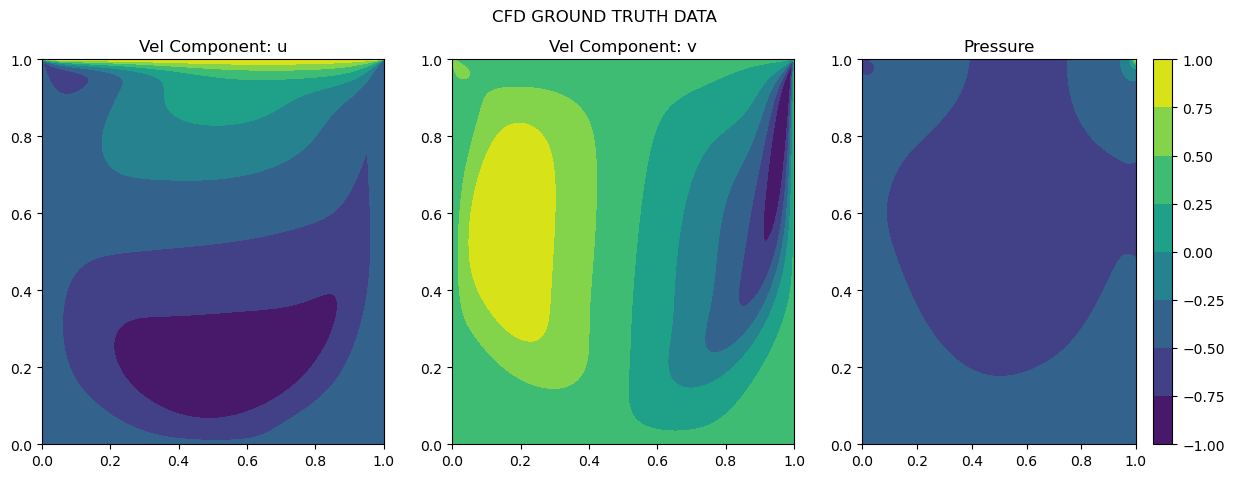

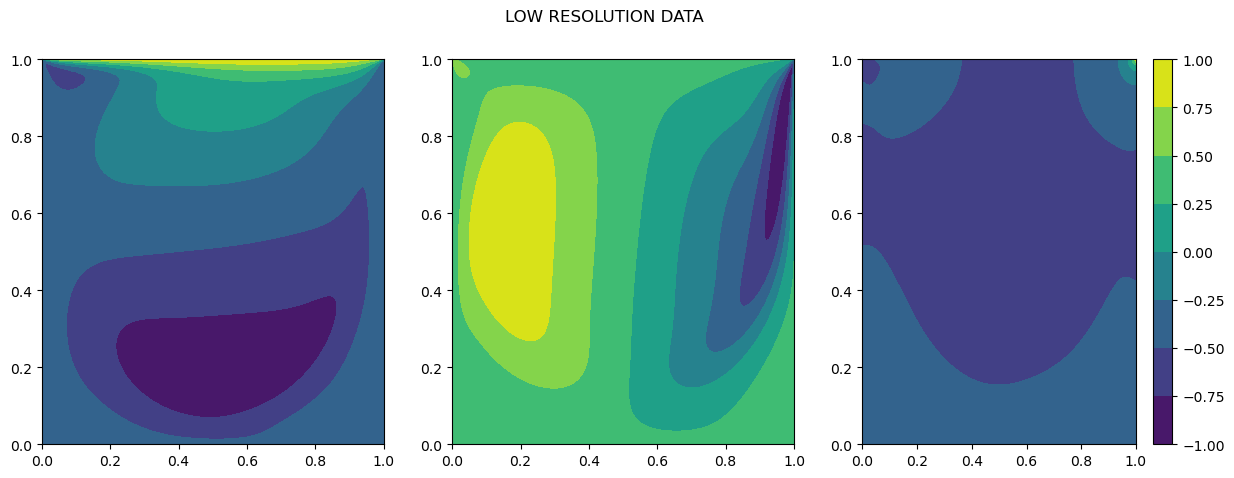

In [5]:
# DOWNSAMPLING OF DATA FOR CNN TRAINING
factor = 2
N = int(Nx/factor)
ULR = np.zeros((N, N))
VLR = np.zeros((N, N))
PLR = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        ULR[i, j] = u[(i*factor*Nx)+ j*factor]
        VLR[i, j] = v[(i*factor*Nx)+ j*factor]
        PLR[i, j] = p[(i*factor*Nx)+ j*factor]
        
# NORMALISATION OF DATA
UmaxLR = np.max(ULR)
UminLR = np.min(ULR)
ULR = (ULR - UmaxLR)/ (UmaxLR- UminLR) + (ULR - UminLR)/ (UmaxLR- UminLR)

VmaxLR = np.max(VLR)
VminLR = np.min(VLR)
VLR  = (VLR - VmaxLR)/(VmaxLR - VminLR) + (VLR - VminLR)/(VmaxLR - VminLR)

PmaxLR = np.max(PLR)
PminLR = np.min(PLR)
PLR  = (PLR - PmaxLR)/(PmaxLR - PminLR) + (PLR - PminLR)/(PmaxLR - PminLR)
        
xgrid = np.linspace(0, 1.0, N)
ygrid = np.linspace(0, 1.0, N)
XLR, YLR = np.meshgrid(xgrid, ygrid)

fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=3);

#****************************************** GORUND TRUTH DATA ************************************************#

xgrid = np.linspace(0, 1.0, Nx)
ygrid = np.linspace(0, 1.0, Nx)
X, Y = np.meshgrid(xgrid, ygrid)

# SAVE THE CFD RESULTS IN IMAGE FORMATS
#plt.contourf(X, Y, U)
#plt.axis('off')
#plt.savefig("U_vel.png", dpi = 1000, bbox_inches='tight',pad_inches = 0)

ax = plt.subplot(1, 3, 1)                                      # VELOCITY COMPONENT: u
plt.contourf(X, Y, U)
ax.title.set_text('Vel Component: u')

ax = plt.subplot(1, 3, 2)                                      # VELOCITY COMPONENT: v
plt.contourf(X, Y, V)
ax.title.set_text('Vel Component: v')

ax = plt.subplot(1, 3, 3)                                      # PRESSURE
plt.contourf(X, Y, P)
plt.colorbar()
ax.title.set_text('Pressure')
plt.suptitle("CFD GROUND TRUTH DATA")
plt.show()

#****************************************** LOW RESOLUTION DATA ************************************************#
fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=3);

ax = plt.subplot(1, 3, 1)                                      # VELOCITY COMPONENT: u
plt.contourf(XLR, YLR, ULR)

ax = plt.subplot(1, 3, 2)                                      # VELOCITY COMPONENT: v
plt.contourf(XLR, YLR, VLR)

ax = plt.subplot(1, 3, 3)                                      # PRESSURE
plt.contourf(XLR, YLR, PLR)
plt.colorbar()
plt.suptitle("LOW RESOLUTION DATA")
plt.show()

In [6]:
#****************************************** Gaussian Noise ************************************************#
def GAUSSIAN_NOISE(field_data, N):
    data = np.full((1, 1, field_data.shape[0], field_data.shape[1]), 0)
    for i in range (N+1):
        noise = np.random.normal(0, (i/100), size=field_data.shape)
        noise_data = field_data + noise
        data = np.append(data, noise_data[np.newaxis, np.newaxis, :, :], axis = 0)
    return data [1:-1, :, :, :]

N_data = 30                           

U_noise = GAUSSIAN_NOISE(ULR, N_data)
V_noise = GAUSSIAN_NOISE(VLR, N_data)
P_noise = GAUSSIAN_NOISE(ULR, N_data)


In [7]:
# DERIVATIVE FUNCTIONS
def CDS(N, P):
    dx = 1.0 / (N-1)
    dP_dxx = torch.zeros(N-2, N-2)
    dP_dyy = torch.zeros(N-2, N-2)
    for i in range(1, N-2):
        for j in range(1, N-2):
            dP_dxx [i , j] = ( P[i+1, j] -2*P[i, j] + P[i-1, j] ) / (dx**2)
            dP_dyy [i , j] = ( P[i, j+1] -2*P[i, j] + P[i, j-1] ) / (dx**2)
    return dP_dxx, dP_dyy

def UPWS(N, P):
    dx = 1.0 / (N-1)
    dP_dx = torch.zeros(N-2, N-2)
    dP_dy = torch.zeros(N-2, N-2)
    for i in range(1, N-2):
        for j in range(1, N-2): 
            dP_dy [i , j] = ( P[i+1, j] - P[i, j] ) / dx
            dP_dx [i , j] = ( P[i, j+1] - P[i, j] ) / dx
    return dP_dx, dP_dy


In [8]:
# LOSS FUNCTIONS
DU = torch.tensor(UmaxLR - UminLR).to(processor)
DV = torch.tensor(VmaxLR - VminLR).to(processor)
DP = torch.tensor(PmaxLR - PminLR).to(processor)

R1 = torch.tensor((UmaxLR - UminLR)/(VmaxLR - VminLR)).to(processor)

def NSE_LOSS(batch, N, U, V, P):    
    loss_f    = nn.MSELoss()
    loss_CONT = 0.
    loss_NSE  = 0.
    
    for i in range(batch):
        u = torch.squeeze(U[i, :, :, :]).to(processor)
        v = torch.squeeze(V[i, :, :, :]).to(processor)
        p = torch.squeeze(P[i, :, :, :]).to(processor)
        
        # FIRST DERIVATIVE
        du_dx, du_dy = UPWS (N, u)
        du_dx, du_dy = du_dx.to(processor), du_dy.to(processor)
        dv_dx, dv_dy = UPWS (N, v)
        dv_dx, dv_dy = dv_dx.to(processor), dv_dy.to(processor)
        dP_dx, dP_dy = UPWS (N, p)
        dP_dx, dP_dy = dP_dx.to(processor), dP_dy.to(processor)
    
        # SECOND DERIVATIVE
        du_dxx, du_dyy = CDS (N, u)
        du_dxx, du_dyy = du_dxx.to(processor), du_dyy.to(processor)
        dv_dxx, dv_dyy = CDS (N, v)
        dv_dxx, dv_dyy = dv_dxx.to(processor), dv_dyy.to(processor)
        
        # CONTINUITY EQUATION
        EQ1 = R1*du_dx + dv_dy
    
        # MOMENTUM EQUATION
        Unorm = torch.squeeze(0.50 * (U[i, :, 1:N-1, 1:N-1]*DU + UminLR + UmaxLR))
        Vnorm = torch.squeeze(0.50 * (V[i, :, 1:N-1, 1:N-1]*DV + VminLR + VmaxLR))
        Pnorm = torch.squeeze(0.50 * (P[i, :, 1:N-1, 1:N-1]*DP + PminLR + PmaxLR))
        
        EQ2 = Unorm*0.50*DU*du_dx + Vnorm*0.50*DU*du_dy + 0.50*DP*dP_dx/rho + diffusion * 0.50*DU*(du_dxx + du_dyy)
        EQ3 = Unorm*0.50*DV*dv_dx + Vnorm*0.50*DV*dv_dy + 0.50*DP*dP_dy/rho + diffusion * 0.50*DV*(dv_dxx + dv_dyy)
    
        
    loss_CONT = loss_CONT + loss_f(EQ1, torch.zeros_like(EQ1)) 
    loss_NSE  = loss_NSE  + loss_f(EQ2, torch.zeros_like(EQ2)) +  loss_f(EQ3, torch.zeros_like(EQ3))
    
    return loss_CONT, loss_NSE


U = torch.Tensor(U).to(torch.float32).to(processor).detach()
V = torch.Tensor(V).to(torch.float32).to(processor).detach()
P = torch.Tensor(P).to(torch.float32).to(processor).detach()

def DATA_LOSS(batch, N, U, V, P, UD, VD, PD):
        
    loss_f    = nn.MSELoss()
    loss_data = 0.0
    
    for i in range(batch):
        u = torch.squeeze(U[i, :, :, :]).to(processor)
        v = torch.squeeze(V[i, :, :, :]).to(processor)
        p = torch.squeeze(P[i, :, :, :]).to(processor)
        loss_data = loss_data + loss_f(u, UD) + loss_f(v, VD) + loss_f(p, PD)
        
    return loss_data
    
    

In [9]:
# CNN NETWORKS
class Interpolate(nn.Module):
    def __init__(self, size, mode):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, size=self.size, mode=self.mode, align_corners=True)
        return x

class UCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            Interpolate(size=(Nx, Nx), mode='bicubic'),
            nn.Conv2d(1, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.GELU(),
            
            nn.Conv2d(128, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.GELU(),
            
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.GELU(),
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.GELU(),
            
            nn.Conv2d(64, 128, kernel_size=4, padding=2),
            nn.BatchNorm2d(128),
            nn.GELU(),
            
            nn.Conv2d(128, 1, kernel_size=4, padding=1),
            nn.BatchNorm2d(1),
            nn.GELU()
        )

    def forward(self, x):
        output = self.main(x)
        #output [-1, :] = 1.0               # TOP WALL BOUNDARY CONDITION
        return output
    
class VCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            Interpolate(size=(Nx, Nx), mode='bicubic'),
            nn.Conv2d(1, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.GELU(),
            
            nn.Conv2d(128, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.GELU(),
            
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.GELU(),
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.GELU(),
            
            nn.Conv2d(64, 128, kernel_size=4, padding=2),
            nn.BatchNorm2d(128),
            nn.GELU(),
            
            nn.Conv2d(128, 1, kernel_size=4, padding=1),
            nn.BatchNorm2d(1),
            nn.GELU()
        )

    def forward(self, x):
        output = self.main(x)
        return output

class PCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            Interpolate(size=(Nx, Nx), mode='bicubic'),
            nn.Conv2d(1, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.GELU(),
            
            nn.Conv2d(128, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.GELU(),
            
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.GELU(),
            
            nn.Conv2d(32, 64, kernel_size=4, padding=2),
            nn.BatchNorm2d(64),
            nn.GELU(),
            
            nn.Conv2d(64, 128, kernel_size=4, padding=2),
            nn.BatchNorm2d(128),
            nn.GELU(),
            
            nn.Conv2d(128, 1, kernel_size=3, padding=0),
            nn.BatchNorm2d(1),
            nn.GELU()
        )

    def forward(self, x):
        output = self.main(x)
        return output
    
UNN = UCNN().to(processor)
VNN = VCNN().to(processor)
PNN = PCNN().to(processor)


In [10]:
# TRAINING DATA 
U_train = torch.Tensor(U_noise[0:3, :, :, :]).to(processor)
V_train = torch.Tensor(V_noise[0:3, :, :, :]).to(processor)
P_train = torch.Tensor(P_noise[0:3, :, :, :]).to(processor)

# VALIDATION DATA
U_valid = torch.Tensor(U_noise[4, :, :, :]).to(processor)
V_valid = torch.Tensor(V_noise[4, :, :, :]).to(processor)
P_valid = torch.Tensor(P_noise[4, :, :, :]).to(processor)

# TEST DATA
U_test = torch.Tensor(U_noise[-1, :, :, :]).to(processor)
V_test = torch.Tensor(V_noise[-1, :, :, :]).to(processor)
P_test = torch.Tensor(P_noise[-1, :, :, :]).to(processor)

batchsize  = 5

train_data = DataLoader(TensorDataset(U_train, V_train, P_train), batch_size=batchsize, shuffle=True,  drop_last = False)
valid_data = DataLoader(TensorDataset(U_valid, V_valid, P_valid), batch_size=batchsize, shuffle=True,  drop_last = False)
test_data  = DataLoader(TensorDataset(U_test,  V_test,  P_test) , batch_size=batchsize, shuffle=True,  drop_last = False)


In [11]:
epochs = 50
learning_rate = 1e-3
decay_rate    = 0.50
step_epoch    = 25

optim_UNN  = optim.Adam(UNN.parameters(),  lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
optim_VNN  = optim.Adam(VNN.parameters(),  lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
optim_PNN  = optim.Adam(PNN.parameters(),  lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

# DYNAMIC LEARNING RATE
scheduler_UNN = torch.optim.lr_scheduler.StepLR(optim_UNN,  step_size=step_epoch, gamma=decay_rate)
scheduler_VNN = torch.optim.lr_scheduler.StepLR(optim_VNN,  step_size=step_epoch, gamma=decay_rate)
scheduler_PNN = torch.optim.lr_scheduler.StepLR(optim_PNN,  step_size=step_epoch, gamma=decay_rate)

LOSS_NSE  = []
LOSS_CONT = []
LOSS_DATA = []

print("*"*85)
for epoch in range (epochs):
    loss_NSE  = 0.
    loss_CONT = 0.
    loss_DATA = 0.
    for index, (u_batch, v_batch, p_batch) in enumerate(train_data):
        u_out = UNN(u_batch)
        v_out = VNN(v_batch)
        p_out = PNN(p_batch)
        batch_nse, batch_cont = NSE_LOSS (u_out.shape[0], Nx, u_out, v_out, p_out)
        batch_data = DATA_LOSS (u_out.shape[0], Nx, u_out, v_out, p_out, U, V, P)
        loss = batch_nse + batch_cont + batch_data
        optim_UNN.zero_grad()
        optim_VNN.zero_grad()
        optim_PNN.zero_grad()
        loss.backward()
        
        with torch.no_grad():  
            optim_UNN.step()
            optim_VNN.step()
            optim_PNN.step()

            loss_NSE   += batch_nse
            loss_CONT  += batch_cont
            loss_DATA  += batch_data
        
    ELOSS_NSE  = loss_NSE/(index +1)
    ELOSS_CONT = loss_CONT/(index +1)
    ELOSS_DATA = loss_DATA/(index +1)
    
    LOSS_NSE.append(ELOSS_NSE)
    LOSS_CONT.append(ELOSS_CONT)
    LOSS_DATA.append(ELOSS_DATA)
    
    print('TOTAL AVERAGE LOSS OF NN PER EPOCH, [EPOCH =', epoch,']\nNSE LOSS     :', ELOSS_NSE.item(), '\nCONT LOSS    :', ELOSS_CONT.item(), '\nDATA LOSS    :', ELOSS_DATA.item())
    print('LEARNING RATE:', optim_UNN.param_groups[0]['lr'])
    print("*"*85)
    scheduler_UNN.step()
    scheduler_VNN.step()
    scheduler_PNN.step()
        

*************************************************************************************
TOTAL AVERAGE LOSS OF NN PER EPOCH, [EPOCH = 0 ]
NSE LOSS     : 5623.560546875 
CONT LOSS    : 0.00042032310739159584 
DATA LOSS    : 3.1043567657470703
LEARNING RATE: 0.001
*************************************************************************************
TOTAL AVERAGE LOSS OF NN PER EPOCH, [EPOCH = 1 ]
NSE LOSS     : 45.123687744140625 
CONT LOSS    : 1.6558115021325648e-06 
DATA LOSS    : 3.1286773681640625
LEARNING RATE: 0.001
*************************************************************************************
TOTAL AVERAGE LOSS OF NN PER EPOCH, [EPOCH = 2 ]
NSE LOSS     : 40.978553771972656 
CONT LOSS    : 1.7544419961268432e-06 
DATA LOSS    : 3.1812374591827393
LEARNING RATE: 0.001
*************************************************************************************
TOTAL AVERAGE LOSS OF NN PER EPOCH, [EPOCH = 3 ]
NSE LOSS     : 41.770015716552734 
CONT LOSS    : 2.020817873926717e-06 
DATA

TOTAL AVERAGE LOSS OF NN PER EPOCH, [EPOCH = 31 ]
NSE LOSS     : 20.86705780029297 
CONT LOSS    : 1.5724444892839529e-06 
DATA LOSS    : 2.7808609008789062
LEARNING RATE: 0.0005
*************************************************************************************
TOTAL AVERAGE LOSS OF NN PER EPOCH, [EPOCH = 32 ]
NSE LOSS     : 20.55642318725586 
CONT LOSS    : 1.2657114893954713e-06 
DATA LOSS    : 2.7701425552368164
LEARNING RATE: 0.0005
*************************************************************************************
TOTAL AVERAGE LOSS OF NN PER EPOCH, [EPOCH = 33 ]
NSE LOSS     : 20.398609161376953 
CONT LOSS    : 1.348956857327721e-06 
DATA LOSS    : 2.7600367069244385
LEARNING RATE: 0.0005
*************************************************************************************
TOTAL AVERAGE LOSS OF NN PER EPOCH, [EPOCH = 34 ]
NSE LOSS     : 20.148324966430664 
CONT LOSS    : 1.363008095722762e-06 
DATA LOSS    : 2.7511820793151855
LEARNING RATE: 0.0005
**************************

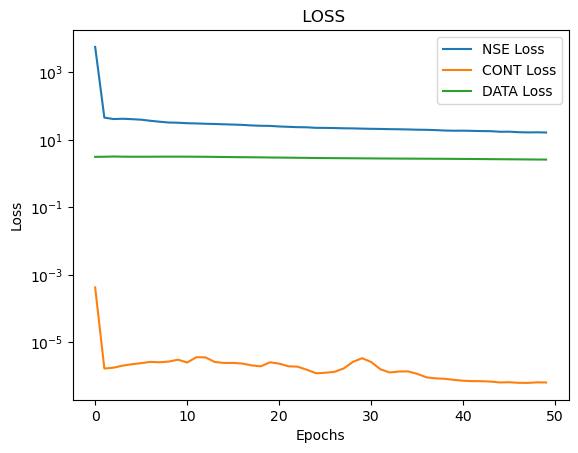

In [12]:
#PLOTTING THE TRAINING PERFORMANCE
NSE = torch.tensor(LOSS_NSE, device = 'cpu').detach().numpy()
CONT = torch.tensor(LOSS_CONT, device = 'cpu').detach().numpy()
DATA = torch.tensor(LOSS_DATA, device = 'cpu').detach().numpy()
plt.plot(range(NSE.shape[0]), NSE,  label = "NSE Loss")
plt.plot(range(NSE.shape[0]), CONT, label = "CONT Loss")
plt.plot(range(NSE.shape[0]), DATA, label = "DATA Loss")
plt.yscale('log')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' LOSS')
plt.show()


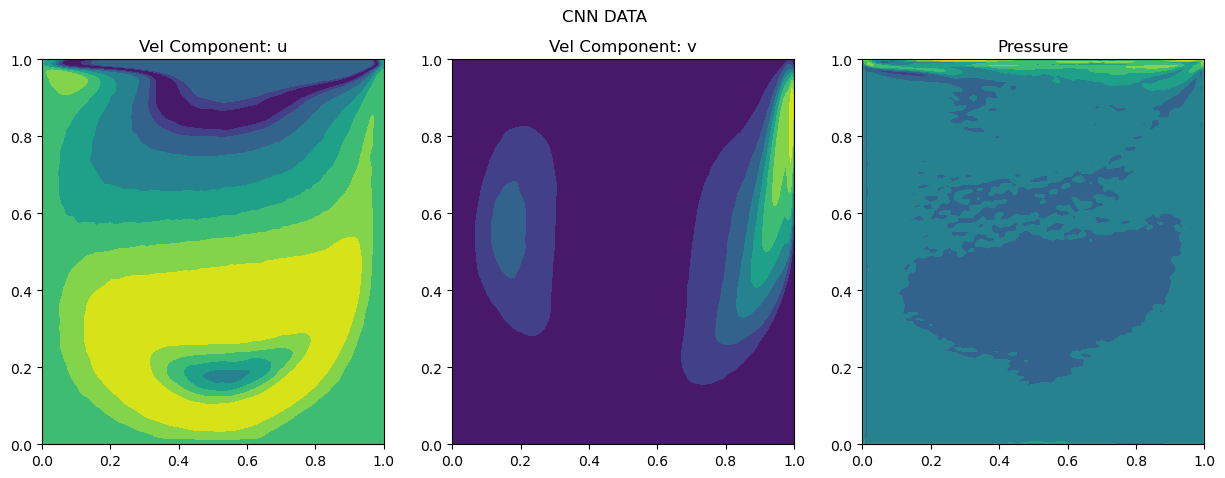

In [13]:
# PLOTTING THE SUPER REOLSUTION & DENOISED FLOWFIELDS
UNN.eval().to('cpu')
VNN.eval().to('cpu')
PNN.eval().to('cpu')

u = torch.squeeze(UNN(torch.Tensor(U_noise[np.newaxis, 1, :, :, :]))).detach().numpy()
v = torch.squeeze(VNN(torch.Tensor(V_noise[np.newaxis, 1, :, :, :]))).detach().numpy()
p = torch.squeeze(PNN(torch.Tensor(P_noise[np.newaxis, 1, :, :, :]))).detach().numpy()


# NORMALISATION OF DATA
UmaxLR = np.max(u)
UminLR = np.min(u)
u  = (u - UmaxLR)/ (UmaxLR- UminLR) + (u - UminLR)/ (UmaxLR- UminLR)

VmaxLR = np.max(v)
VminLR = np.min(v)
v  = (v - VmaxLR)/(VmaxLR - VminLR) + (v - VminLR)/(VmaxLR - VminLR)

PmaxLR = np.max(p)
PminLR = np.min(p)
p  = (p - PmaxLR)/(PmaxLR - PminLR) + (p - PminLR)/(PmaxLR - PminLR)

fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=3);

ax = plt.subplot(1, 3, 1)                                      # VELOCITY COMPONENT: u
plt.contourf(X, Y, u)
ax.title.set_text('Vel Component: u')

ax = plt.subplot(1, 3, 2)                                      # VELOCITY COMPONENT: v
plt.contourf(X, Y, v)
ax.title.set_text('Vel Component: v')

ax = plt.subplot(1, 3, 3)                                      # PRESSURE
plt.contourf(X, Y, p)
#plt.colorbar()
ax.title.set_text('Pressure')
plt.suptitle("CNN DATA")
plt.show()

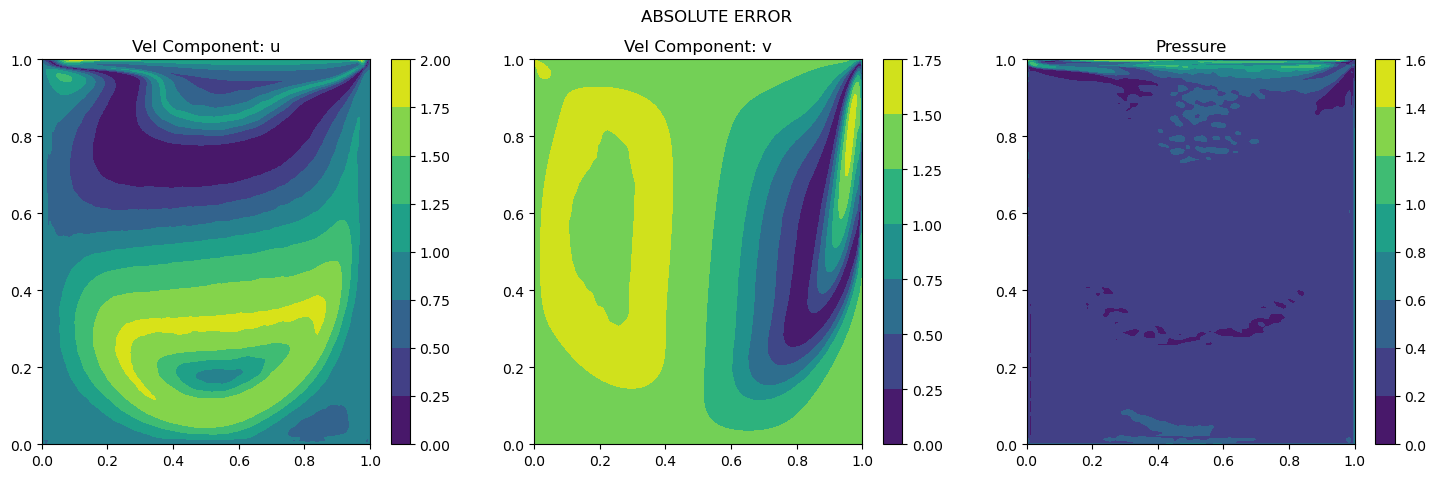

In [21]:
# ***** READING THE SOLUTION FILE
data  = np.genfromtxt('CFD_Solution.csv', delimiter=",")
Nx    = int(np.sqrt(data.shape[0]))                          # RESOLUTION OF A GRID

ud = data[:, 5]
vd = data[:, 6]
pd = data[:, 2]

U = np.zeros((Nx, Nx))
V = np.zeros((Nx, Nx))
P = np.zeros((Nx, Nx))

for i in range(Nx):
    for j in range(Nx):
        U[i, j] = ud[(i*Nx)+ j]
        V[i, j] = vd[(i*Nx)+ j]
        P[i, j] = pd[(i*Nx)+ j]
        
# NORMALISATION OF DATA
Umax = np.max(U)
Umin = np.min(U)
U = (U - Umax)/ (Umax- Umin) + (U - Umin)/ (Umax- Umin)

Vmax = np.max(V)
Vmin = np.min(V)
V = (V - Vmax)/(Vmax - Vmin) + (V - Vmin)/(Vmax - Vmin)

Pmax = np.max(P)
Pmin = np.min(P)
P = (P - Pmax)/(Pmax - Pmin) + (P - Pmin)/(Pmax - Pmin)

fig, ax = plt.subplots(figsize=(18,5), nrows=1, ncols=3);

ax = plt.subplot(1, 3, 1)                                      # VELOCITY COMPONENT: u
plt.contourf(X, Y, np.abs(u-U))
plt.colorbar()
ax.title.set_text('Vel Component: u')

ax = plt.subplot(1, 3, 2)                                      # VELOCITY COMPONENT: v
plt.contourf(X, Y, np.abs(v-V))
plt.colorbar()
ax.title.set_text('Vel Component: v')

ax = plt.subplot(1, 3, 3)                                      # PRESSURE
plt.contourf(X, Y, np.abs(p-P))
plt.colorbar()
ax.title.set_text('Pressure')
plt.suptitle("ABSOLUTE ERROR")
plt.show()